## Module Imports

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import \
    balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import \
    LearningCurveDisplay, validation_curve, train_test_split, ShuffleSplit,\
          GridSearchCV, cross_validate, ValidationCurveDisplay
import torch
from torch import nn
from torch import tensor
from torch import optim
import timeit

# Set Random Seed

In [2]:
# set numpy seed
np.random.seed(123321)
# set python seed
random.seed(123321)

## Data Processing

In [3]:
red_wine = os.path.join('data','wine', 'winequality-red.csv')
white_wine = os.path.join('data','wine', 'winequality-white.csv')
turbine = os.path.join('data','turbine','gt_2011.csv')
mushrooms = os.path.join('data','mushroom','secondary_data.csv')

In [4]:
# encoders to use
scale = StandardScaler()
s_split = ShuffleSplit()
ohe = OneHotEncoder(sparse_output=False)

## SHROOM DATA

In [5]:
transformer = make_column_transformer(
    (
        ohe, 
        [
        'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color',
        'has-ring', 'ring-type', 'spore-print-color','habitat', 'season'
        ]
        ),
    remainder='passthrough'
    )

In [6]:
shroom_df = pd.read_csv(mushrooms,sep=';').sample(frac=1).reset_index(drop=True)
x = shroom_df.iloc[:,1:].copy()
x_shroom = pd.DataFrame(transformer.fit_transform(x), 
                columns=transformer.get_feature_names_out())
y = shroom_df.iloc[:,0].copy()
y_shroom = (y == 'p')


# reduce the number of training examples
x_shroom = x_shroom[:7000]
y_shroom =  y_shroom[:7000]

In [7]:
sum(y_shroom)

3870

In [8]:
x_shroom.shape

(7000, 128)

## WINE DATA

In [9]:
white_df = pd.read_csv(white_wine, sep=';')
red_df = pd.read_csv(red_wine, sep=';')
white_df['type'] = 0
red_df['type'] = 1
wine_df = pd.concat([white_df,red_df])
wine_df = wine_df.sample(frac=1).reset_index(drop=True)

In [10]:
# set x and y values
# remove 'quality' and 'type' column from x array
x_wine = wine_df.iloc[:,:-2].copy()
# scale x vals
x_wine.values[:,:] = scale.fit_transform(x_wine)
# set y array equal to 'type' column 
y_wine = wine_df.iloc[:,-1].copy()

## Shroom and Wine Train/Test Split

In [11]:
x_shroom_train, x_shroom_test, y_shroom_train, y_shroom_test = train_test_split(x_shroom, y_shroom, test_size=0.2)

In [12]:
x_wine_train, x_wine_test, y_wine_train, y_wine_test = train_test_split(x_wine, y_wine, test_size=0.2)

## Model Instantiation

In [13]:
#########################################################
## DT: Pruning
## Boosting: # of Weak Learners
## NN: Hidden Layer Size (Width, Depth)
## SVM: Kernel Type
## KNN: K
#########################################################
svc = SVC()
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
ada = AdaBoostClassifier()
mlp = MLPClassifier()

## Wine: Hyperparameter Tuning

In [14]:
# SVC hyper tuning
# defining parameter range 
param_grid = {'C': np.linspace(0.01, 10, 20),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  
   
grid = GridSearchCV(svc, param_grid, scoring='f1', refit = True,\
                     verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_wine_train, y_wine_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
svc_wine = grid.best_estimator_
# grid_predictions = grid.predict(x_wine_test)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'C': 2.6389473684210527, 'kernel': 'rbf'}


In [117]:
# Decision Tree Classifier hyper tuning
# defining parameter range 
param_grid = {'max_depth': np.arange(1, 100, 10, dtype=int),
              'criterion':['gini', 'entropy', 'log_loss'], 
              'splitter': ['best']
              }
   
grid = GridSearchCV(dtc, param_grid, scoring='f1', refit = True,\
                     verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_wine_train, y_wine_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
dtc_wine = grid.best_estimator_
# grid_predictions = grid.predict(x_wine_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'criterion': 'gini', 'max_depth': 31, 'splitter': 'best'}


In [16]:
# Nearest Neighbor hyper tuning
# defining parameter range 
param_grid = {'n_neighbors': np.arange(1, 100, 10, dtype=int),
              'algorithm':['kd_tree', 'ball_tree', 'brute'], 
              'metric':['euclidean', 'manhattan']
              }    
   
grid = GridSearchCV(knn, param_grid, scoring='f1', refit = True,\
                     verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_wine_train, y_wine_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
knn_wine = grid.best_estimator_
# grid_predictions = grid.predict(x_wine_test)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 1}


In [17]:
# Boosted Tree hyper tuning
# defining parameter range 
param_grid = {'n_estimators': np.arange(1, 100, 10, dtype=int),
              'learning_rate': np.linspace(0.01, 10, 10)}  

grid = GridSearchCV(ada, param_grid, scoring='f1', refit = True,\
                     verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_wine_train, y_wine_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
ada_wine = grid.best_estimator_
# grid_predictions = grid.predict(x_wine_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'learning_rate': 1.12, 'n_estimators': 91}


In [18]:
# Neural Network hyper tuning
# defining parameter range 
param_grid = {
'learning_rate': ["constant"],
'hidden_layer_sizes': [(1,),(10,),(20,),(50,),(70,),(100,)],
'learning_rate_init': np.linspace(0.01, 1, 10),
'activation': ['relu'],
'solver': ['sgd']
}

grid = GridSearchCV(mlp, param_grid, scoring='f1', refit = True,\
                     verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_wine_train, y_wine_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
mlp_wine = grid.best_estimator_
# grid_predictions = grid.predict(x_wine_test)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant', 'learning_rate_init': 0.67, 'solver': 'sgd'}


## Shrooms: Hyperparameter Tuning 

In [19]:
# SVC hyper tuning
# defining parameter range 
param_grid = {'C': np.linspace(0.01, 10, 20),
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}  
   
grid = GridSearchCV(svc, param_grid, scoring='f1', refit = True,\
                     verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_shroom_train, y_shroom_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
svc_shroom = grid.best_estimator_
# grid_predictions = grid.predict(x_shroom_test)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'C': 10.0, 'kernel': 'rbf'}


In [116]:
# Decision Tree Classifier hyper tuning
# defining parameter range 
param_grid = {'max_depth': np.arange(1, 100, 10, dtype=int),
              'criterion':['gini', 'entropy', 'log_loss'], 
              'splitter': ['best']
              }
   
grid = GridSearchCV(dtc, param_grid, scoring='f1', refit = True,\
                     verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_shroom_train, y_shroom_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
dtc_shroom = grid.best_estimator_
# grid_predictions = grid.predict(x_shroom_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'criterion': 'gini', 'max_depth': 31, 'splitter': 'best'}


In [21]:
# Nearest Neighbor hyper tuning
# defining parameter range 
param_grid = {'n_neighbors': np.arange(1, 100, 10, dtype=int),
              'algorithm':['kd_tree', 'ball_tree', 'brute'], 
              'metric':['euclidean', 'manhattan']
              }    
   
grid = GridSearchCV(knn, param_grid, scoring='f1', refit = True,\
                     verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_shroom_train, y_shroom_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
knn_shroom = grid.best_estimator_
# grid_predictions = grid.predict(x_shroom_test)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'algorithm': 'kd_tree', 'metric': 'manhattan', 'n_neighbors': 1}


In [22]:
# Boosted Tree hyper tuning
# defining parameter range 
param_grid = {'n_estimators': np.arange(1, 100, 10, dtype=int),
              'learning_rate': np.linspace(0.01, 10, 10)}

grid = GridSearchCV(ada, param_grid, scoring='f1', refit = True,\
                     verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_shroom_train, y_shroom_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
ada_shroom = grid.best_estimator_
# grid_predictions = grid.predict(x_shroom_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'learning_rate': 1.12, 'n_estimators': 81}


In [23]:
# Neural Network hyper tuning
# defining parameter range 
param_grid = {
'learning_rate': ["constant"],
'hidden_layer_sizes': [(1,),(10,),(20,),(50,),(70,),(100,)],
'learning_rate_init': np.linspace(0.01, 1, 10),
'activation': ['relu'],
'solver': ['sgd']
}

grid = GridSearchCV(mlp, param_grid, scoring='f1',\
                     refit = True, verbose = 3,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_shroom_train, y_shroom_train) 
 
# print best parameter after tuning 
print(grid.best_params_)
mlp_shroom = grid.best_estimator_
# grid_predictions = grid.predict(x_shroom_test)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'activation': 'relu', 'hidden_layer_sizes': (70,), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'sgd'}


## Wine Data Learning Curve

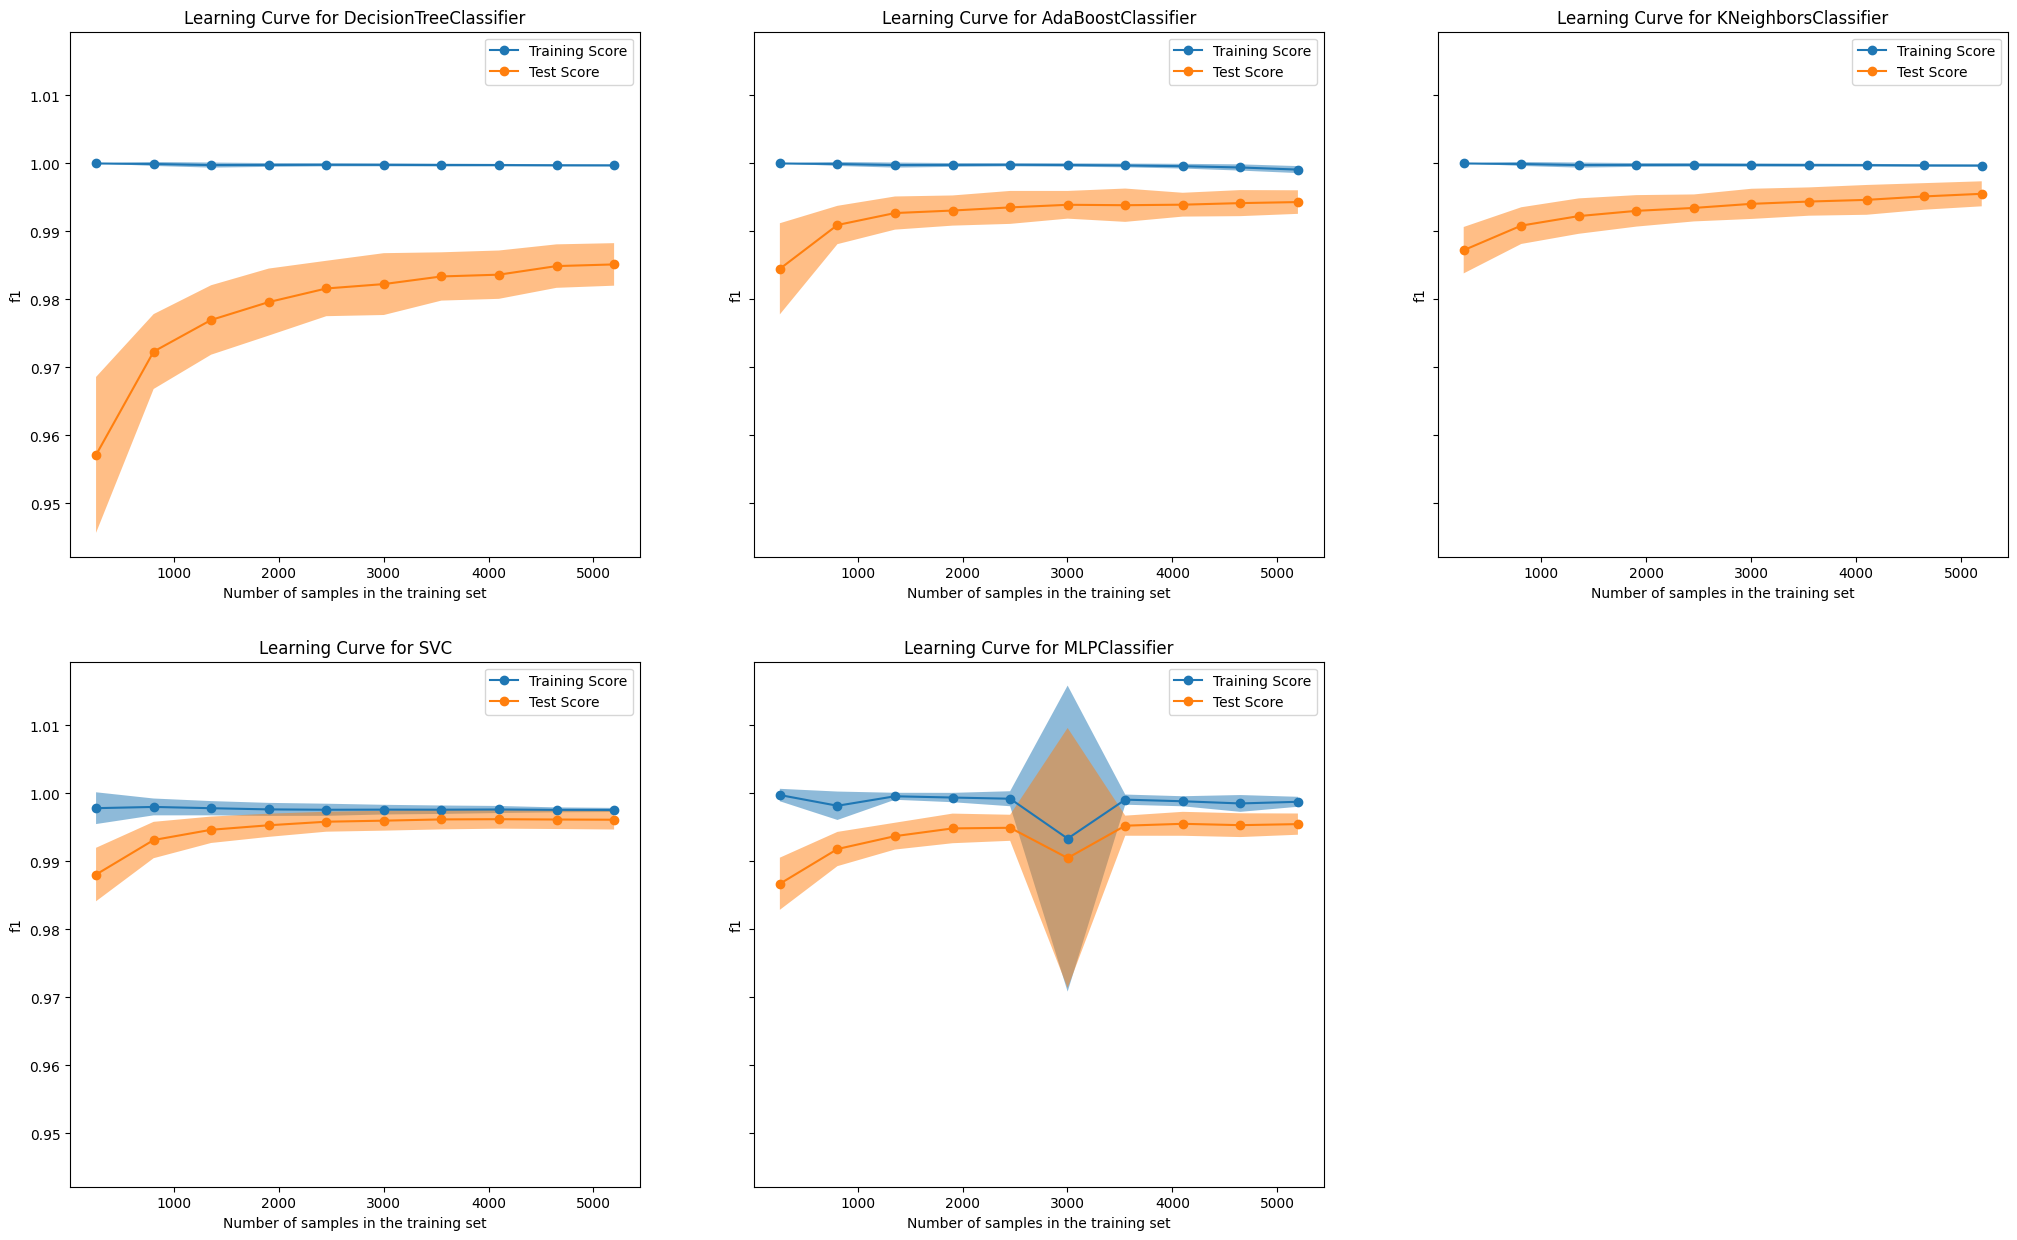

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 15), sharey=True)
ax = ax.flatten()
fig.suptitle('Learnings Curves for Wine Dataset', fontsize='xx-large')
fig.delaxes(ax[5])
common_params = {
    "X": x_wine,
    "y": y_wine,
    "train_sizes": np.linspace(0.05, 1.0, 10),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1",
}

for ax_idx, estimator in enumerate([dtc_wine, ada_wine, knn_wine, svc_wine, mlp_wine]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}", fontsize=15)
    ax[ax_idx].tick_params(axis='both', which='major', labelsize=15)
    ax[ax_idx].tick_params(axis='both', which='minor', labelsize=15)


## Shroom Data Learning Curve

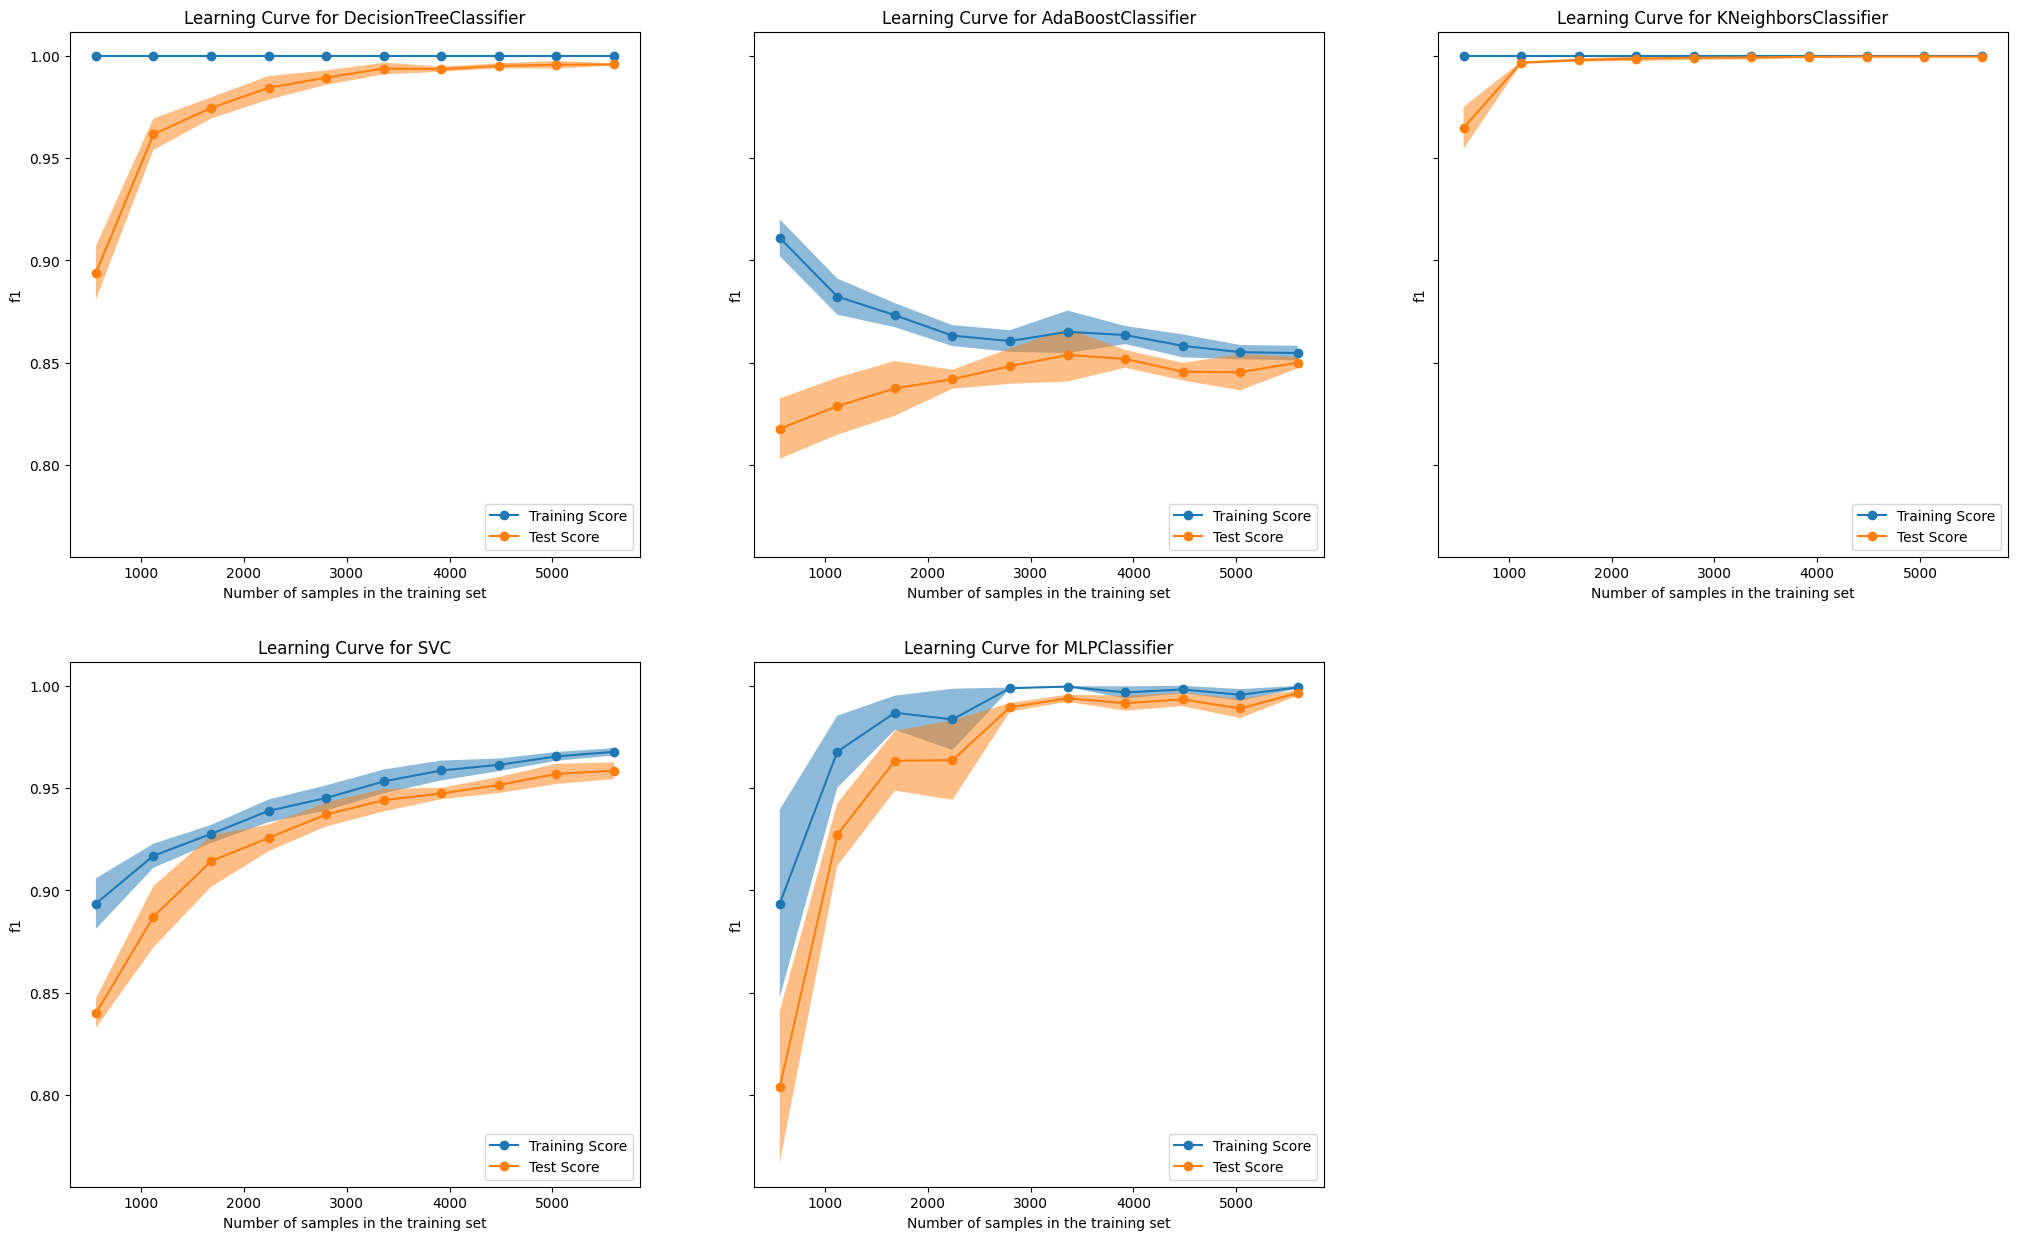

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 15), sharey=True)
ax = ax.flatten()
fig.delaxes(ax[5])
fig.suptitle('Learnings Curves for Mushroom Dataset', fontsize='xx-large')
common_params = {
    "X": x_shroom,
    "y": y_shroom,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": ShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": 'f1',
}

for ax_idx, estimator in enumerate([dtc_shroom, ada_shroom, knn_shroom, svc_shroom, mlp_shroom]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"], loc='lower right')
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}", fontsize=15)
    ax[ax_idx].set_xlabel(fontsize = 15)
    ax[ax_idx].set_ylabel(fontsize = 15)
    ax[ax_idx].tick_params(axis='both', which='major', labelsize=15)
    ax[ax_idx].tick_params(axis='both', which='minor', labelsize=15)
    

## Wine Validation Curve

In [51]:
# SVC
svc_val_curve_wine = validation_curve(
    svc_wine,
    x_wine_test,
    y_wine_test,
    param_name='C',
    param_range=np.linspace(0.01, 10, 20),
    scoring='f1',
    n_jobs=4,
)

# DTC
dtc_val_curve_wine = validation_curve(
    dtc_wine,
    x_wine_test,
    y_wine_test,
    # param_name='min_samples_leaf',
    param_name='max_depth',
    param_range= np.arange(1, 100, 10, dtype=int),
    scoring='f1',
    n_jobs=4,
)

# Adaboost
ada_val_curve_wine = validation_curve(
    ada_wine,
    x_wine_test,
    y_wine_test,
    param_name='n_estimators',
    param_range= np.arange(1, 100, 10, dtype=int),
    scoring='f1',
    n_jobs=4,
)

# KNN
knn_val_curve_wine = validation_curve(
    knn_wine,
    x_wine_test,
    y_wine_test,
    param_name='n_neighbors',
    param_range= np.arange(1, 100, 10, dtype=int),
    scoring='f1',
    n_jobs=4,
)

# Neural
neural_val_curve_wine = validation_curve(
    mlp_wine,
    x_wine_test,
    y_wine_test,
    param_name='hidden_layer_sizes',
    param_range= [(1,),(5,),(15,),(30,),(60,),(100,)],
    scoring='f1',
    n_jobs=4,
)


## Shroom Validation Curve

In [52]:
# SVC
svc_val_curve_shroom = validation_curve(
    svc_shroom,
    x_shroom_test,
    y_shroom_test,
    param_name='C',
    param_range=np.linspace(0.01, 10, 20),
    scoring='f1',
    n_jobs=4,
)

# DTC
dtc_val_curve_shroom = validation_curve(
    dtc_shroom,
    x_shroom_test,
    y_shroom_test,
    # param_name='min_samples_leaf',
    param_name='max_depth',
    param_range= np.arange(1, 100, 10, dtype=int),
    scoring='f1',
    n_jobs=4,
)

# Adaboost
ada_val_curve_shroom = validation_curve(
    ada_shroom,
    x_shroom_test,
    y_shroom_test,
    param_name='n_estimators',
    param_range= np.arange(1, 100, 10, dtype=int),
    scoring='f1',
    n_jobs=4,
)

# KNN
knn_val_curve_shroom = validation_curve(
    knn_shroom,
    x_shroom_test,
    y_shroom_test,
    param_name='n_neighbors',
    param_range= np.arange(1, 100, 10, dtype=int),
    scoring='f1',
    n_jobs=4,
)

# Neural
neural_val_curve_shroom = validation_curve(
    mlp_shroom,
    x_shroom_test,
    y_shroom_test,
    param_name='hidden_layer_sizes',
    param_range= [(1,),(5,),(15,),(30,),(60,),(100,)],
    scoring='f1',
    n_jobs=4,
)

# Plot Validation Curve Function

In [197]:
def plot_validation_curve(val_curve, x_range, param_name, model_name, axs=None,\
                          plot_train=True, plot_test=True):

    train, test = val_curve
    train_mean = train.mean(1)
    train_sd = train.std(1)
    test_mean = test.mean(1)
    test_sd = test.std(1)
    axs = axs
    x = x_range
    if plot_train:
        line, = axs.plot(x,train_mean, 'o-')
        axs.fill_between(x,train_mean + train_sd, train_mean - train_sd,alpha=0.3)
    if plot_test:
        axs.plot(x,test_mean,'o-')
        axs.fill_between(x, test_mean + test_sd, test_mean - test_sd,alpha=0.3)
    axs.set_title(f'{model_name} validation curve', fontsize = 15)
    axs.set_xlabel(f'{param_name}', fontsize = 15)
    axs.set_ylabel(f'f1 score', fontsize = 15)
    axs.legend(handles[:2], ["Training Score", "Test Score"], loc='lower right')
    axs.tick_params(axis='both', which='major', labelsize=15)
    axs.tick_params(axis='both', which='minor', labelsize=15)

    return line

# Generate Wine Validation Curves

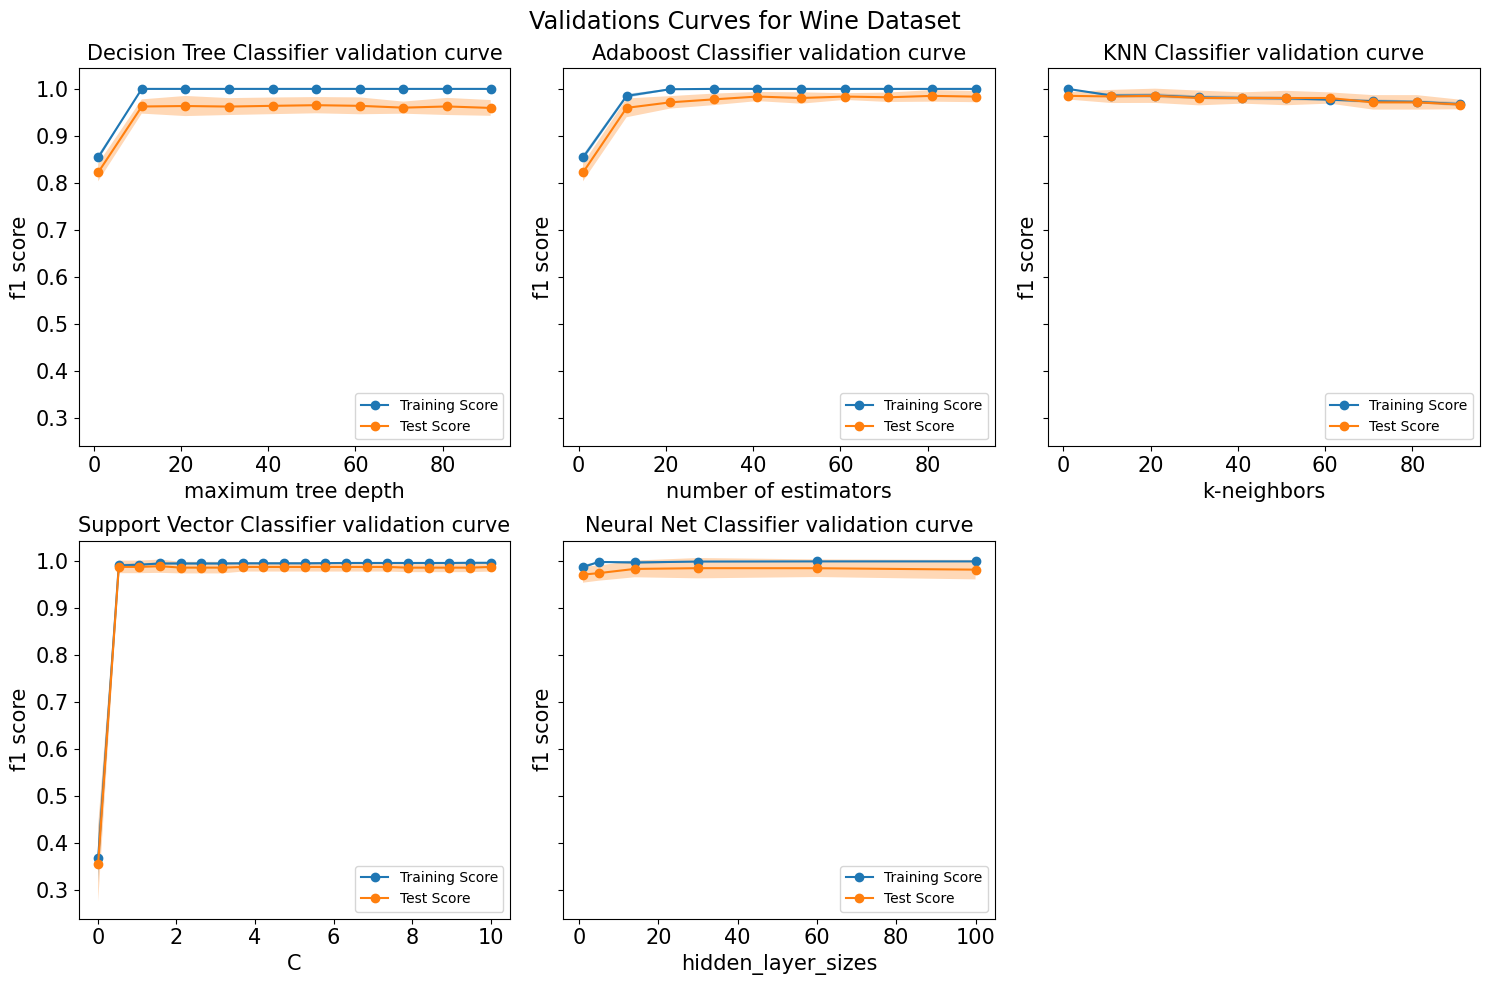

In [198]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True)
axs = axs.flatten()
plot_validation_curve(val_curve=dtc_val_curve_wine,\
                        x_range=np.arange(1, 100, 10, dtype=int),\
                        param_name='maximum tree depth',
                        model_name='Decision Tree Classifier', axs=axs[0]
                               )

plot_validation_curve(val_curve=ada_val_curve_wine,\
                        x_range=np.arange(1, 100, 10, dtype=int),\
                        param_name='number of estimators',
                        model_name='Adaboost Classifier', axs=axs[1]
                               )

plot_validation_curve(val_curve=knn_val_curve_wine,\
                        x_range=np.arange(1, 100, 10, dtype=int),\
                        param_name='k-neighbors',
                        model_name='KNN Classifier', axs=axs[2]
                               )

plot_validation_curve(val_curve=svc_val_curve_wine,\
                        x_range=np.linspace(0.01, 10, 20),\
                        param_name='C',
                        model_name='Support Vector Classifier', axs=axs[3]
                               )

plot_validation_curve(val_curve=neural_val_curve_wine,\
                        x_range=[1,5,14,30,60,100],\
                        param_name='hidden_layer_sizes',
                        model_name='Neural Net Classifier', axs=axs[4]
                               )

fig.delaxes(axs[5])
fig.suptitle('Validations Curves for Wine Dataset', fontsize='xx-large')
plt.tight_layout()

plt.show()

# Generate Shroom Validation Curves

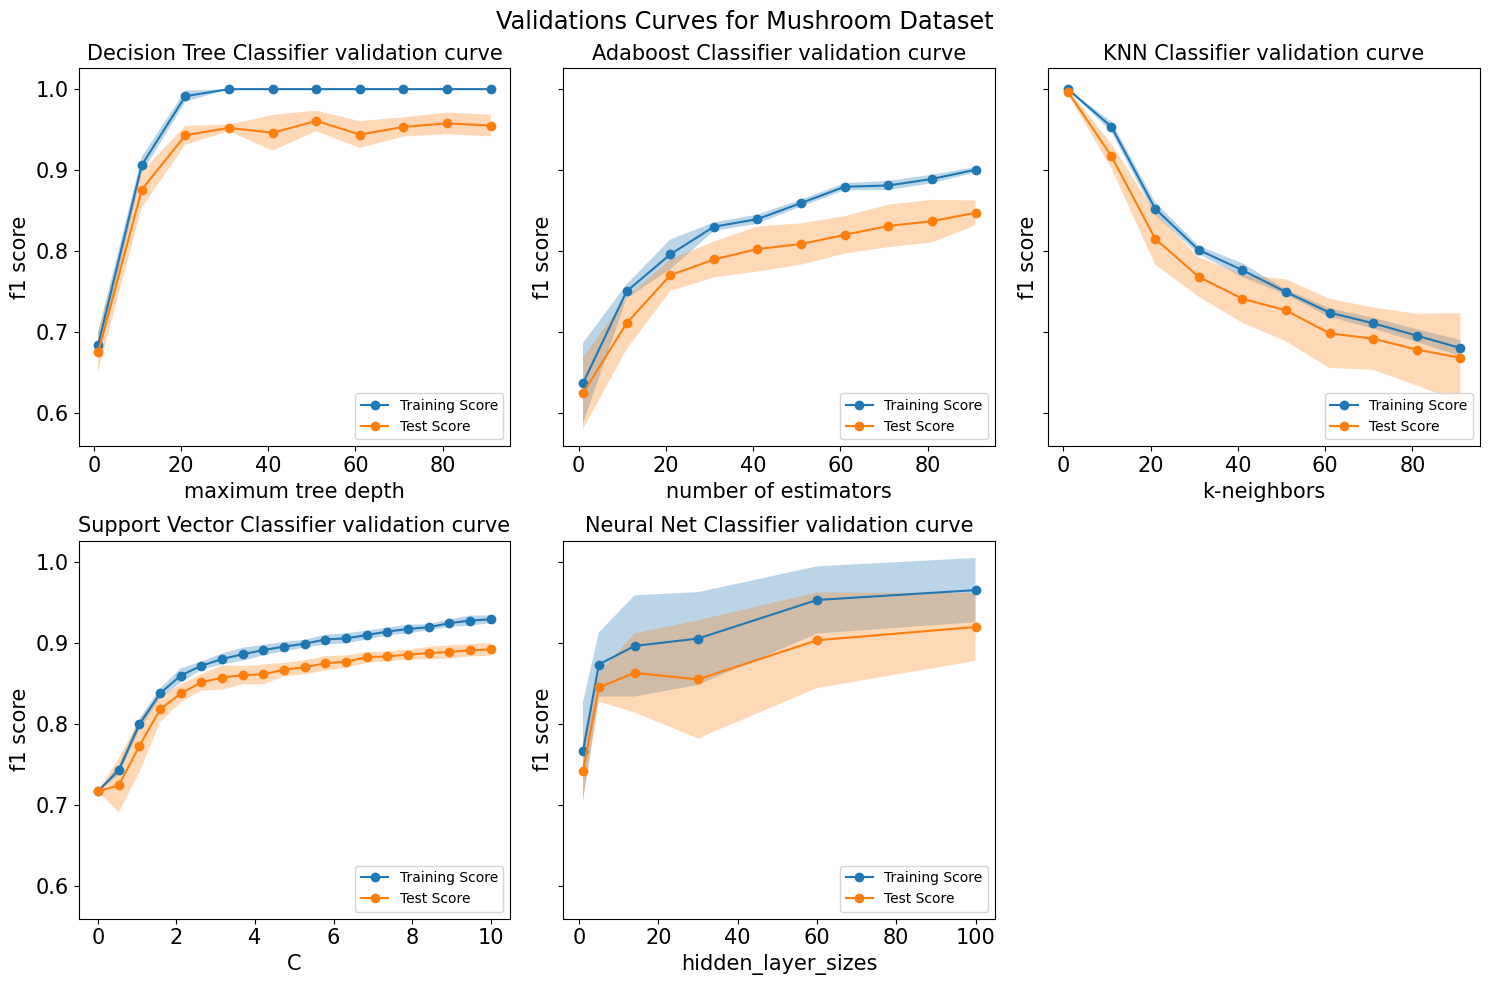

In [199]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15,10), sharey=True)
axs = axs.flatten()
plot_validation_curve(val_curve=dtc_val_curve_shroom,\
                        x_range=np.arange(1, 100, 10, dtype=int),\
                        param_name='maximum tree depth',
                        model_name='Decision Tree Classifier', axs=axs[0]
                               )

plot_validation_curve(val_curve=ada_val_curve_shroom,\
                        x_range=np.arange(1, 100, 10, dtype=int),\
                        param_name='number of estimators',
                        model_name='Adaboost Classifier', axs=axs[1]
                               )

plot_validation_curve(val_curve=knn_val_curve_shroom,\
                        x_range=np.arange(1, 100, 10, dtype=int),\
                        param_name='k-neighbors',
                        model_name='KNN Classifier', axs=axs[2]
                               )

plot_validation_curve(val_curve=svc_val_curve_shroom,\
                        x_range=np.linspace(0.01, 10, 20),\
                        param_name='C',
                        model_name='Support Vector Classifier', axs=axs[3]
                               )

plot_validation_curve(val_curve=neural_val_curve_shroom,\
                        x_range=[1,5,14,30,60,100],\
                        param_name='hidden_layer_sizes',
                        model_name='Neural Net Classifier', axs=axs[4]
                               )

fig.delaxes(axs[5])
fig.suptitle('Validations Curves for Mushroom Dataset', fontsize='xx-large')

plt.tight_layout()

plt.show()

## Neural Net Loss Curves

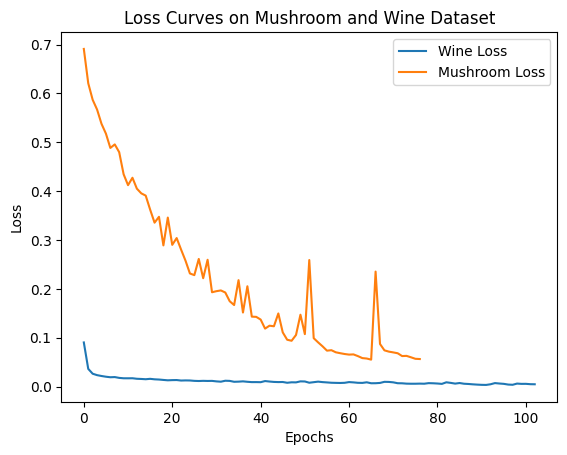

In [74]:
fig, ax = plt.subplots()
ax.plot(mlp_wine.loss_curve_, )
ax.plot(mlp_shroom.loss_curve_)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss Curves on Mushroom and Wine Dataset')
ax.legend(["Wine Loss", "Mushroom Loss"], loc='upper right')
plt.show()

## Support Vector Machine Method Comparisons

In [ ]:
# SVC Shroom
svc_val_curve_shroom_kernels = validation_curve(
    svc_shroom,
    x_shroom_test,
    y_shroom_test,
    param_name='kernel',
    param_range=['linear', 'poly', 'rbf','sigmoid'],
    scoring='f1',
    n_jobs=4,
)

svc_val_curve_wine_kernels = validation_curve(
    svc_wine,
    x_wine_test,
    y_wine_test,
    param_name='kernel',
    param_range=['linear', 'poly', 'rbf','sigmoid'],
    scoring='f1',
    n_jobs=4,
)

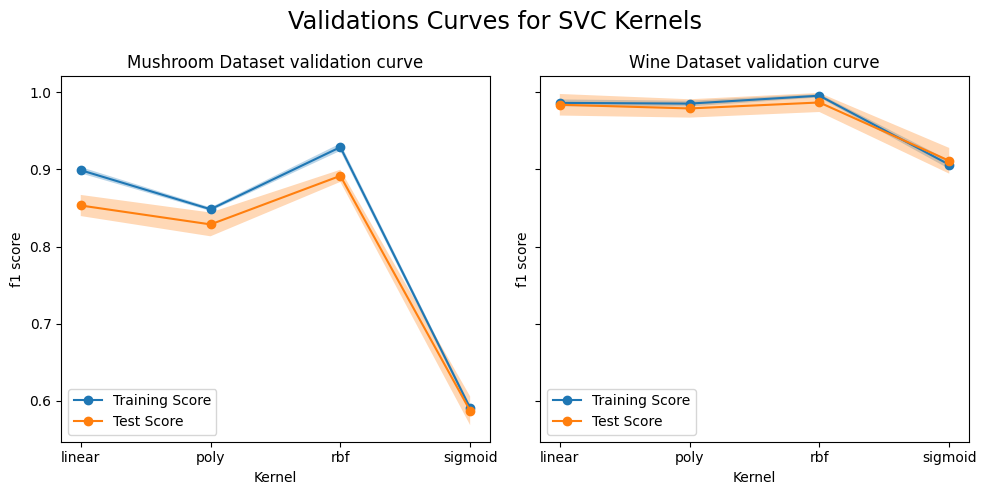

In [94]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)
axs = axs.flatten()

plot_validation_curve(val_curve=svc_val_curve_shroom_kernels,\
                        x_range=['linear', 'poly', 'rbf','sigmoid'],\
                        param_name='Kernel',
                        model_name='Mushroom Dataset', axs=axs[0]
                               )

plot_validation_curve(val_curve=svc_val_curve_wine_kernels,\
                        x_range=['linear', 'poly', 'rbf','sigmoid'],\
                        param_name='Kernel',
                        model_name='Wine Dataset', axs=axs[1]
                               )

fig.suptitle('Validations Curves for SVC Kernels', fontsize='xx-large')
axs[0].legend(handles[:2], ["Training Score", "Test Score"], loc='lower left')
axs[1].legend(handles[:2], ["Training Score", "Test Score"], loc='lower left')
plt.tight_layout()

plt.show()

## Training and Query Time Curves

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [183]:
# sklearn citatio: https://scikit-learn.org/1.0/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(
    estimator,
    X,
    y,
    axes=None,
    cv=None,
    n_jobs=-1,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):


    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    scoring_times_mean = np.mean(score_times, axis=1)
    scoring_times_std = np.std(score_times, axis=1)

    # Plot n_samples vs fit_times
    line = axes.plot(train_sizes, fit_times_mean, "o-")
    axes.fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )

    # Plot n_samples vs query_times
    axes.plot(train_sizes, scoring_times_mean, "o-")
    axes.fill_between(
        train_sizes,
        scoring_times_mean - scoring_times_std,
        scoring_times_mean + scoring_times_std,
        alpha=0.1,
    )
    axes.set_xlabel("Training Examples", fontsize = 15)
    axes.set_ylabel("Time (seconds)", fontsize = 15)
    axes.set_title(f"Time Complexity of {estimator.__class__.__name__}", fontsize = 15)
    axes.legend(handles[:2], ["Training Time", "Query Time"], loc='upper right')
    axs.tick_params(axis='both', which='major', labelsize=15)
    axs.tick_params(axis='both', which='minor', labelsize=15)

    return line

## Wine Time Complexity

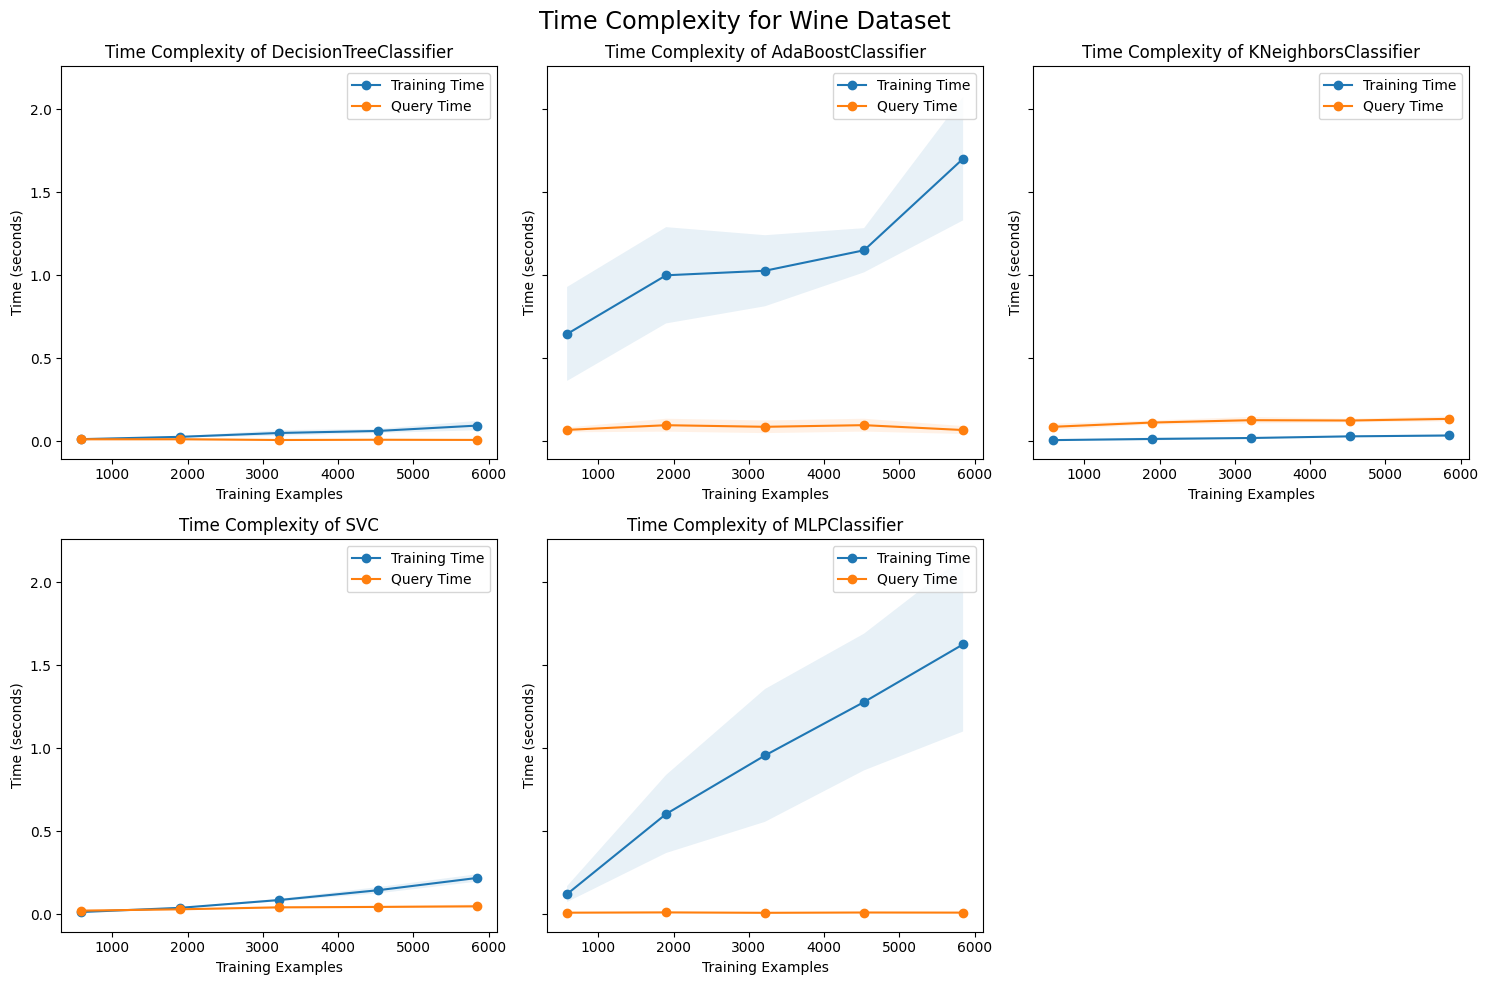

In [186]:
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(15,10), sharey=True)
axs = axs.flatten()
train_size_lst = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit()
plot_learning_curve(
    dtc_wine,
    x_wine,
    y_wine,
    axes=axs[0],
    cv=cv,
    scoring='f1',
    train_sizes= train_size_lst,
)
plot_learning_curve(
    ada_wine,
    x_wine,
    y_wine,
    axes=axs[1],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
)
plot_learning_curve(
    knn_wine,
    x_wine,
    y_wine,
    axes=axs[2],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
)
plot_learning_curve(
    svc_wine,
    x_wine,
    y_wine,
    axes=axs[3],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
)
plot_learning_curve(
    mlp_wine,
    x_wine,
    y_wine,
    axes=axs[4],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
)
fig.suptitle('Time Complexity for Wine Dataset', fontsize='xx-large')
fig.delaxes(axs[5])
fig.tight_layout()
plt.show()

## Shroom Time Complexity

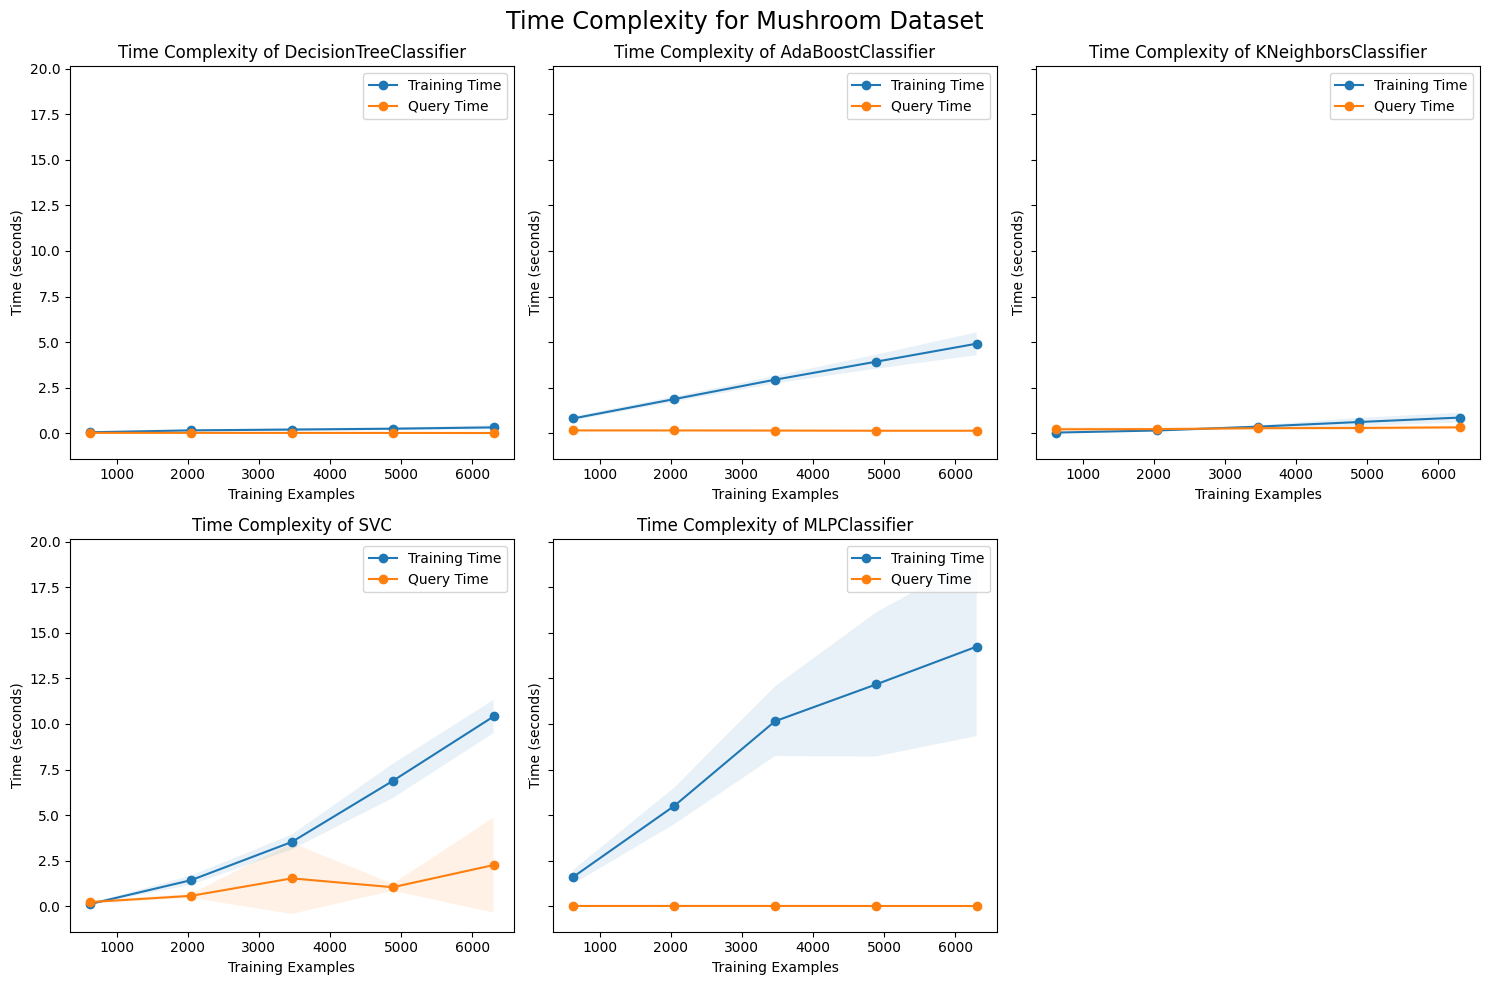

In [187]:
fig, axs = plt.subplots(nrows=2,ncols=3, figsize=(15,10), sharey=True)
axs = axs.flatten()
train_size_lst = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit()
plot_learning_curve(
    dtc_shroom,
    x_shroom,
    y_shroom,
    axes=axs[0],
    cv=cv,
    scoring='f1',
    train_sizes= train_size_lst,
)
plot_learning_curve(
    ada_shroom,
    x_shroom,
    y_shroom,
    axes=axs[1],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
)
plot_learning_curve(
    knn_shroom,
    x_shroom,
    y_shroom,
    axes=axs[2],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
)
plot_learning_curve(
    svc_shroom,
    x_shroom,
    y_shroom,
    axes=axs[3],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
)
plot_learning_curve(
    mlp_shroom,
    x_shroom,
    y_shroom,
    axes=axs[4],
    cv=cv,
    scoring='f1',
    train_sizes=train_size_lst,
)
fig.suptitle('Time Complexity for Mushroom Dataset', fontsize='xx-large')
fig.delaxes(axs[5])
fig.tight_layout()
plt.show()